In [1]:
import os, sys, re, datetime, shutil, copy, subprocess
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.table import Table
from collections import OrderedDict
sys.path.insert(1, os.path.join(os.path.dirname(os.getcwd()), 'utils'))
radex_bin_path = os.path.expanduser('~/Cloud/Github/Crab.Toolkit.michi2.make.libs/make_lib_LVG/01_RadiativeTransferCode/RADEX/bin/radex_LVG')
radex_data_path = os.path.expanduser('~/Cloud/Github/Crab.Toolkit.michi2.make.libs/make_lib_LVG/01_RadiativeTransferCode/RADEX/data')
radex_calc_path = os.path.expanduser('~/Cloud/GitLab/COExcitation/tmp/calc_radex') # '/tmp/calc_radex'
LTE_calc_path = os.path.expanduser('~/Cloud/GitLab/COExcitation/tmp/calc_LTE')

In [2]:
# User defined global parameters

list_of_N_CO = 10**np.arange(17.0, 20.0, 0.25)
list_of_X_CICO = np.arange(0.05, 1.0+0.05, 0.05)
list_of_n_H2 = [1e2, 1e3, 1e4, 1e5, 1e6]
#list_of_T_kin = [15., 25., 50., 100.] # len=npanel
#list_of_d_V_for_T_kin = [4., 10., 50., 90.] # len=npanel
#list_of_CO_abundance_for_T_kin = [3e-4, 3e-4, 3e-4, 3e-4] # len=npanel
list_of_T_kin = [15., 20., 50., 100.] # len=npanel
list_of_d_V_for_T_kin = [4., 10., 50., 90.] # len=npanel
list_of_CO_abundance_for_T_kin = [1e-4, 2e-4, 3e-4, 3e-4] # len=npanel
#line_width = 30. * u.km/u.s

#in_table_name = 'out_table_RADEX_R_CI10CO21_sim_XCICO_1pX'
#in_table_name = 'out_table_RADEX_R_CI10CO21_sim_XCICO_dv_%gkms'%(line_width)
in_table_name_by_d_V = {}
for d_V in list_of_d_V_for_T_kin:
    d_V_str = '%g'%(d_V)
    if d_V_str not in in_table_name_by_d_V:
        in_table_name = 'out_table_RADEX_R_CI10CO21_sim_XCICO_dv_%gkms'%(d_V)
        in_table_name_by_d_V[d_V_str] = in_table_name

select_X_CICO = 0.2 # no difference for CO

#X_CO_H2 = 3e-4
#out_fig_name = 'Plot_RADEX_alpha_CO21_sim_XCOH2_3e-4'

#X_CO_H2 = 2e-4
#out_fig_name = 'Plot_RADEX_alpha_CO21_sim_XCOH2_2e-4'

out_fig_name = 'Plot_RADEX_alpha_CO21_varied_CO_abundance'

out_fig_size = (20, 4.2) # RADEX includes n_H2 = 1e2, so wider figure

out_fig_margin = {'left':0.08, 'right':0.945, 'bottom':0.18, 'top':0.75}


In [3]:
# calc_Q

CO = {}
CO['Einstein_A'] = np.array([
    7.203e-08, 6.910e-07, 2.497e-06, 6.126e-06, 1.221e-05, 2.137e-05, 3.422e-05, 5.134e-05, 7.330e-05, 1.006e-04, 
    1.339e-04, 1.735e-04, 2.200e-04, 2.739e-04, 3.354e-04, 4.050e-04, 4.829e-04, 5.695e-04, 6.650e-04, 7.695e-04, 
    8.833e-04, 1.006e-03, 1.139e-03, 1.281e-03, 1.432e-03, 1.592e-03, 1.761e-03, 1.940e-03, 2.126e-03, 2.321e-03, 
    2.524e-03, 2.735e-03, 2.952e-03, 3.175e-03, 3.404e-03, 3.638e-03, 3.878e-03, 4.120e-03, 4.365e-03, 4.613e-03, 
])
CO['E_u'] = np.array([
    5.53,      16.60,   33.19,   55.32,   82.97,  116.16,  154.87,  199.11,  248.88, 304.16, 
    364.97,   431.29,  503.13,  580.49,  663.35,  751.72,  845.59,  944.97, 1049.84, 1160.20, 
    1276.05, 1397.38, 1524.19, 1656.47, 1794.23, 1937.44, 2086.12, 2240.24, 2399.82, 2564.83, 
    2735.28, 2911.15, 3092.45, 3279.15, 3471.27, 3668.78, 3871.69, 4079.98, 4293.64, 4512.67, 
])
CO['nu'] = np.array([
     115.2712018,  230.5380000,  345.7959899,  461.0407682,  576.2679305, 
     691.4730763,  806.6518060,  921.7997000, 1036.9123930, 1151.9854520, 
    1267.0144860, 1381.9951050, 1496.9229090, 1611.7935180, 1726.6025057, 
    1841.3455060, 1956.0181390, 2070.6159930, 2185.1346800, 2299.5698420, 
    2413.9171130, 2528.1720600, 2642.3303459, 2756.3875840, 2870.3394070, 
    2984.1814550, 3097.9093610, 3211.5187506, 3325.0052827, 3438.3646110, 
    3551.5923610, 3664.6841800, 3777.6357280, 3890.4427170, 4003.1007876, 
    4115.6055850, 4227.9527744, 4340.1381120, 4452.1571221, 4564.0056399, 
])

CI = {}
CI['Einstein_A'] = np.array([
    7.880E-08, 2.650E-07, 
    #1.810E-14, 
])
CI['E_u'] = np.array([
    23.620, 62.462, 
    # 62.462, 
])
CI['nu'] = np.array([
    492.160651, 809.34197, 
    # 1301.50262, 
])

def calc_Q(E_u, T_kin, N=None):
    E_j = np.concatenate([[0.0], E_u])
    if N is None:
        N = len(E_j)
    j = np.arange(N)
    E_j = E_j[0:N]
    #E_j = (j*(j+1)) * E_u[0]
    return np.sum(1.0 * (j+(j+1)) * np.exp(-1.0 * E_j / T_kin))

def calc_Q_CO(T_kin):
    global CO
    if np.isscalar(T_kin):
        return calc_Q(CO['E_u'], T_kin)
    else:
        return np.array([calc_Q(CO['E_u'], t) for t in T_kin])

def calc_Q_CI(T_kin):
    global CI
    if np.isscalar(T_kin):
        return calc_Q(CI['E_u'], T_kin)
    else:
        return np.array([calc_Q(CI['E_u'], t) for t in T_kin])


In [4]:
# Define function to compute LTE tau

def calc_tau_LTE(
        nu, 
        g_u, 
        Q, 
        A_ul, 
        N_dV, 
        T_kin, 
    ):
    c = const.c.cgs.value # 2.99792458e+10 cm / s
    pi = np.pi
    h = const.h.cgs.value # 6.62607015e-27 erg s
    k = const.k_B.cgs.value # 1.380649e-16 erg / K
    hnu_kt = h*(nu*1e9)/(k*T_kin)
    #print('nu', nu)
    #print('Q', Q)
    #print('c**3/(8.0*pi*(nu*1e9)**3)', c**3/(8.0*pi*(nu*1e9)**3))
    #print('hnu_kt', hnu_kt)
    N_dV_cm_2_km_s_1 = N_dV # input should have a unit of cm^{-2} (km s^{-1})^{-1}
    N_dV_cm_2_cm_s_1 = N_dV_cm_2_km_s_1 / 1e5 # km^{-1} to cm^{-1}
    return c**3/(8.0*pi*(nu*1e9)**3) * (g_u/Q) * A_ul * N_dV_cm_2_cm_s_1 / 1.0645 * (1.0 - np.exp( -hnu_kt ))

def calc_tau_LTE_CO10(T_kin, N_CO, d_V):
    g_u = 2*1+1
    A_ul = 7.203e-08
    Q = calc_Q_CO(T_kin) # 2.0 * T_kin / 5.53
    N_dV = N_CO / d_V
    return calc_tau_LTE(115.2712018, g_u, Q, A_ul, N_dV, T_kin)

def calc_tau_LTE_CO21(T_kin, N_CO, d_V):
    g_u = 2*2+1
    A_ul = 6.910e-07
    Q = calc_Q_CO(T_kin) # 2.0 * T_kin / 5.53
    N_dV = N_CO / d_V
    return calc_tau_LTE(230.5380000, g_u, Q, A_ul, N_dV, T_kin)


In [5]:
# Define function to compute CO to H2

# def calc_CO_to_H2(input_N_CO, input_X_CO_H2, input_Flux_Kkms_CO):
#     # alphaCO = N_CO / X_CO / I_CO
#     # ((1.0*u.cm).to(u.pc)).value**(-2) * (2.0*(const.m_p+const.m_e).cgs/const.M_sun.cgs).value = 1.6027265100590378e-20
#     return input_N_CO / input_X_CO_H2 * 1.6027265100590378e-20 / input_Flux_Kkms_CO


In [6]:
# Read data table, select by X_CICO, and add alphaCO factor

CO10_coe4 = 0.6384841822417346 # s solMass / (K km pc2)
CO10_kfactor = 2.8674592723381087
CO21_coe4 = 0.1597276714880375 # s solMass / (K km pc2)
CO21_kfactor = 5.022034696683453
CI10_coe4 = 0.5319606138812801 # s solMass / (K km pc2)
CI10_kfactor = 7.113087782520815
CI21_coe4 = 0.2566619090909567 # s solMass / (K km pc2)
CI21_kfactor = 11.923220661563994


data_table_by_d_V = {}
for d_V, CO_abundance in list(zip(list_of_d_V_for_T_kin, list_of_CO_abundance_for_T_kin)):
    d_V_str = '%g'%(d_V)
    if d_V_str not in data_table_by_d_V:
        print('Reading "%s"'%(in_table_name_by_d_V[d_V_str] + '.csv'))
        in_table = Table.read(in_table_name_by_d_V[d_V_str] + '.csv', format='csv')
        #print('in_table.colnames', in_table.colnames)
        print('Selecting X_CICO = %s'%(select_X_CICO))
        data_table = in_table[np.isclose(in_table['X_CICO'], select_X_CICO)] # select X_CICO = 1.0
        print('Computing alpha_CO = N_CO / X_CO / I_CO')
        data_table['alpha_CO21_NonLTE'] = data_table['N_CO'] / \
                                          CO_abundance * 1.6027265100590378e-20 / \
                                          data_table['Flux_Kkms_CO21_NonLTE']
        data_table['alpha_CO21_LTE'] = CO21_coe4 * \
                                       (3e-4 / CO_abundance) * \
                                       ((2.0 * data_table['T_kin'] / 5.53 + CO21_kfactor) / 100.0) * \
                                       (data_table['tau_0_CO21_LTE']/(1.0-np.exp(-data_table['tau_0_CO21_LTE'])))
        data_table['alpha_CO21_LTE2'] = data_table['N_CO'] / \
                                        CO_abundance * 1.6027265100590378e-20 / \
                                        data_table['Flux_Kkms_CO21_LTE']
        data_table_by_d_V[d_V_str] = copy.copy(data_table)


# -- In earlier version Flux_Kkms_CO10 was not recorded
# Flux_Kkms_CO10 = []
# for i in range(len(in_table)):
#     T_kin = in_table['T_kin'][i]
#     N_CO = in_table['N_CO'][i]
#     n_H2 = in_table['n_H2'][i]
#     d_V = line_width.value
#     T_kin_str = '%.0f'%(T_kin)
#     N_CO_str = re.sub(r'(.*)(e)(\+0|\+)([0-9]+.*)', r'\1\2\4', '%.2e'%(N_CO))
#     n_H2_str = re.sub(r'(.*)(e)(\+0|\+)([0-9]+.*)', r'\1\2\4', '%.1e'%(n_H2))
#     calc_name = 'calc_T_kin_%s_N_CO_%s_n_H2_%s_d_V_%s'%(T_kin_str, N_CO_str, n_H2_str, d_V)
#     working_dir = os.path.join(radex_calc_path, calc_name)
    
#     this_Flux_Kkms_CO10 = np.nan
#     with open(os.path.join(working_dir, 'co.out'), 'r') as fp:
#         for line_str in fp:
#             if line_str.startswith('#') or line_str.startswith('*'):
#                 continue
#             if line_str.startswith('J_UP') or re.match(r'^\s+(LINE|\(K\)).*', line_str):
#                 continue
#             line_split = line_str.split()
#             line_split = [t for t in line_split if t != '--']
#             if len(line_split) >= 12:
#                 if int(line_split[0]) == 1 and int(line_split[1]) == 0:
#                     this_Flux_Kkms_CO10 = float(line_split[10])
#     Flux_Kkms_CO10.append(this_Flux_Kkms_CO10)

# in_table['Flux_Kkms_CO10'] = Flux_Kkms_CO10


# # alphaCO = N_CO / X_CO / I_CO
# # ((1.0*u.cm).to(u.pc)).value**(-2) * (2.0*(const.m_p+const.m_e).cgs/const.M_sun.cgs).value = 1.6027265100590378e-20
# in_table['alpha_CO10_NonLTE'] = in_table['N_CO'] / X_CO_H2 * ((1.0*u.cm).to(u.pc)).value**(-2) * \
# (2.0*(const.m_p+const.m_e).cgs/const.M_sun.cgs).value / in_table['Flux_Kkms_CO10']

# in_table['tau_CO10_LTE'] = calc_tau_LTE_CO10(in_table['T_kin'], in_table['N_CO'], in_table['line_width'])
# in_table['tau_CO21_LTE'] = calc_tau_LTE_CO21(in_table['T_kin'], in_table['N_CO'], in_table['line_width'])
# in_table['alpha_CO10_LTE'] = 0.38 * (1e-4 / X_CO_H2) * ((2.0 * in_table['T_kin'] / 5.53 + 2.78) / 20.0) * \
#                              (in_table['tau_CO10_LTE']/(1.0-np.exp(-in_table['tau_CO10_LTE'])))

# data_table = in_table[np.isclose(in_table['X_CICO'], select_X_CICO)] # select X_CICO = 1.0
# data_table[np.isclose(data_table['N_CO'], 5e18, rtol=0.2, atol=0.0)]

Reading "out_table_RADEX_R_CI10CO21_sim_XCICO_dv_4kms.csv"
Selecting X_CICO = 0.2
Computing alpha_CO = N_CO / X_CO / I_CO
Reading "out_table_RADEX_R_CI10CO21_sim_XCICO_dv_10kms.csv"


/Users/dzliu/Software/CONDA/miniconda3/envs/condapy37/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide


Selecting X_CICO = 0.2
Computing alpha_CO = N_CO / X_CO / I_CO
Reading "out_table_RADEX_R_CI10CO21_sim_XCICO_dv_50kms.csv"
Selecting X_CICO = 0.2
Computing alpha_CO = N_CO / X_CO / I_CO
Reading "out_table_RADEX_R_CI10CO21_sim_XCICO_dv_90kms.csv"
Selecting X_CICO = 0.2
Computing alpha_CO = N_CO / X_CO / I_CO


In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
from matplotlib import pyplot as plt

# fig = plt.figure(figsize=(5,4))
# ax = fig.add_subplot(1,1,1)
# ax.plot(data_table_by_d_V['30']['alpha_CO10_LTE'], data_table_by_d_V['30']['alpha_CO10_LTE2'])

In [8]:
from matplotlib.patches import Rectangle, FancyBboxPatch

def add_fancy_box(axes, list_of_n_H2, list_of_N_CO):
    axes[0].add_artist(FancyBboxPatch(xy=[np.argmin(np.abs(np.log10(list_of_n_H2)-3.0)),
                                          np.argmin(np.abs(np.log10(list_of_N_CO)-17.75))], 
                                      width=3, height=3, boxstyle='round,pad=0.1',
                                      facecolor='none', edgecolor='k', lw=2))
    axes[1].add_artist(FancyBboxPatch(xy=[np.argmin(np.abs(np.log10(list_of_n_H2)-3.0)),
                                          np.argmin(np.abs(np.log10(list_of_N_CO)-18.00))], 
                                      width=3, height=3, boxstyle='round,pad=0.1',
                                      facecolor='none', edgecolor='k', lw=2))
    axes[2].add_artist(FancyBboxPatch(xy=[np.argmin(np.abs(np.log10(list_of_n_H2)-3.0)),
                                          np.argmin(np.abs(np.log10(list_of_N_CO)-18.50))], 
                                      width=3, height=3, boxstyle='round,pad=0.1',
                                      facecolor='none', edgecolor='k', lw=2))
    axes[3].add_artist(FancyBboxPatch(xy=[np.argmin(np.abs(np.log10(list_of_n_H2)-3.0)),
                                          np.argmin(np.abs(np.log10(list_of_N_CO)-19.00))], 
                                      width=3, height=3, boxstyle='round,pad=0.1',
                                      facecolor='none', edgecolor='k', lw=2))


minima 0.08 maxima 24.0
Output to 'Plot_RADEX_alpha_CO21_varied_CO_abundance_LTE.pdf'


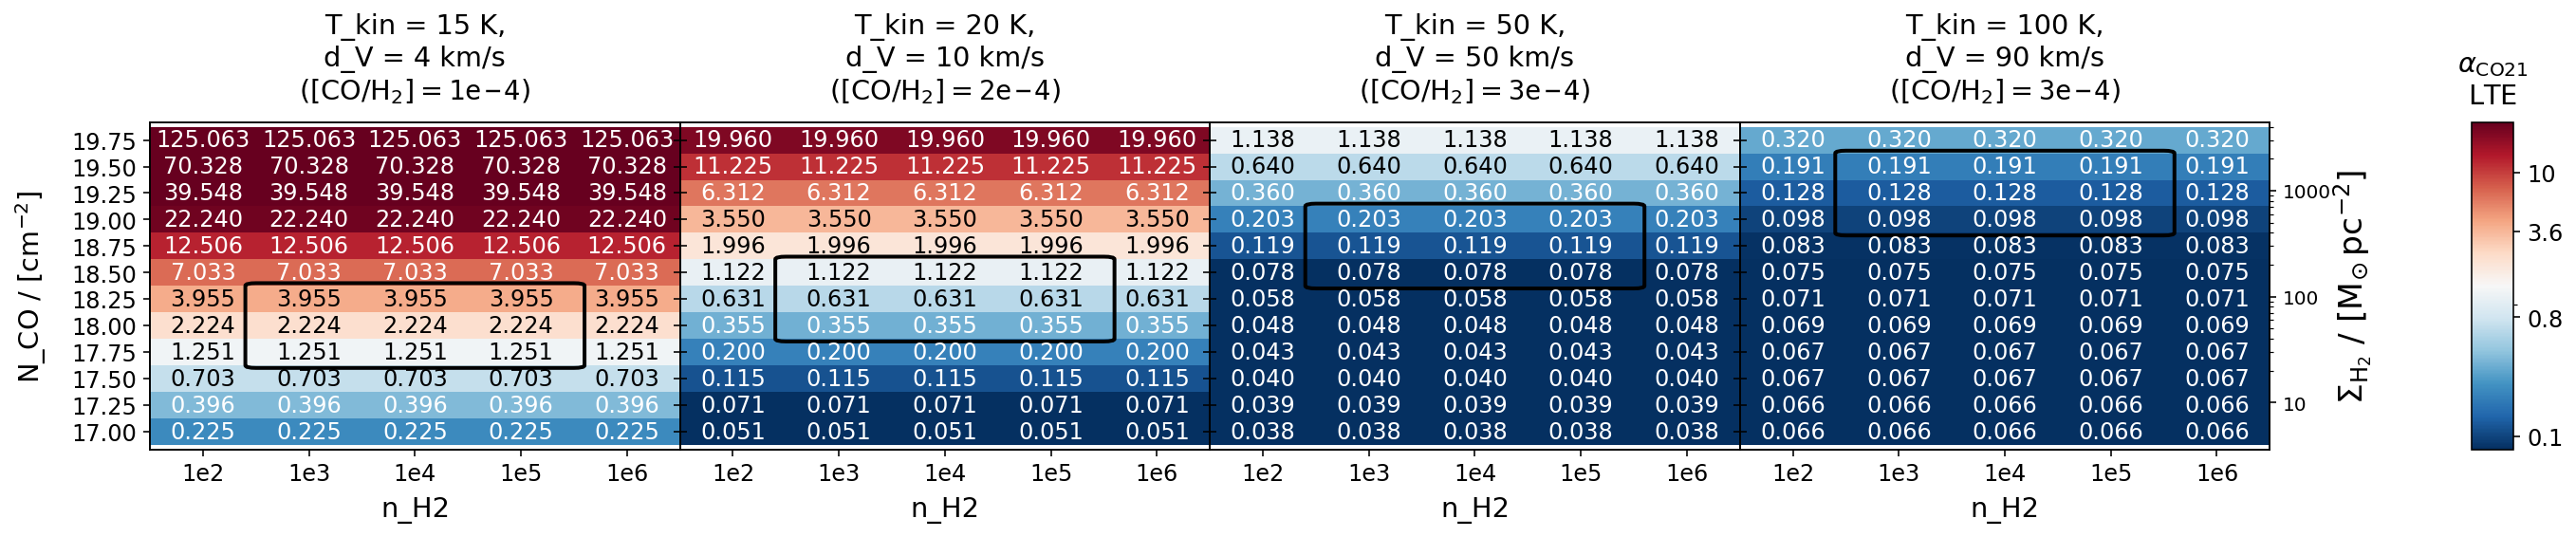

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import ticker

#minima = np.min(data_table['alpha_CO10_LTE'])
#maxima = np.max(data_table['alpha_CO10_LTE'])
#print('minima', minima, 'maxima', maxima)
minima, maxima = 0.08, 24.0
print('minima', minima, 'maxima', maxima)
# norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
norm = matplotlib.colors.LogNorm(vmin=minima, vmax=maxima, clip=True)
cmap = cm.RdBu_r # cm.jet # cm.viridis # cm.RdYlBu_r
colormapper = cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure(figsize=out_fig_size)
fig.subplots_adjust(**out_fig_margin)
gs = gridspec.GridSpec(ncols=len(list_of_T_kin)+2, nrows=1, figure=fig, 
                       width_ratios=[1]*len(list_of_T_kin)+[0.38,0.08], wspace=0, hspace=0)
axes = []
for i in range(len(list_of_T_kin)):
    ax = fig.add_subplot(gs[0, i])
    axes.append(ax)
right_axes = []
for iax, T_kin in enumerate(list_of_T_kin):
    d_V = list_of_d_V_for_T_kin[iax]
    T_kin_str = '%.0f'%(T_kin)
    d_V_str = '%.0f'%(d_V)
    CO_abundance = list_of_CO_abundance_for_T_kin[iax]
    CO_abundance_str = '{:g}e{:g}'.format(CO_abundance/10**np.floor(np.log10(CO_abundance)), 
                                          np.floor(np.log10(CO_abundance)))
    axes[iax].set_xlabel('n_H2', fontsize='x-large', labelpad=6)
    axes[iax].set_xlim([0, len(list_of_n_H2)])
    axes[iax].set_xticks(np.arange(len(list_of_n_H2))+0.5)
    axes[iax].set_xticklabels([('%.0e'%(t)).replace('e+0','e') for t in list_of_n_H2])
    axes[iax].set_ylim([0, len(list_of_N_CO)])
    axes[iax].set_yticks(np.arange(len(list_of_N_CO))+0.5)
    if iax == 0: 
        axes[iax].set_ylabel(r'N_CO / [cm$^{-2}$]', fontsize='x-large', labelpad=12)
        axes[iax].set_yticklabels(['%.2f'%(np.log10(t)) for t in list_of_N_CO])
    else:
        axes[iax].set_yticklabels([])
    axes[iax].tick_params(labelsize='large')
    axes[iax].set_aspect(0.25)
    #axes[iax].set_title(f'T_kin = {T_kin_str} K,' + '\n' + f'd_V = {d_V_str} km/s', fontsize='x-large', pad=12)
    axes[iax].set_title(f'T_kin = {T_kin_str} K,' + '\n' + \
                        f'd_V = {d_V_str} km/s' + '\n' + \
                        r'($[{\mathrm{CO}}/{\mathrm{H_2}}]={\tt{%s}})$'%(CO_abundance_str), 
                        fontsize='x-large', pad=12) # panel title
    right_axes.append(axes[iax].twinx())
    right_axes[iax].set_aspect(0.25)
    right_axes[iax].set_yticks(np.arange(len(list_of_N_CO))+0.5)
    right_axes[iax].set_yticklabels([])
    right_axes[iax].set_ylim(axes[iax].get_ylim())

ax_colorbar = fig.add_subplot(gs[0, -1])
ax_colorbar.set_title(r'$\alpha_{\mathrm{CO21}}$'+'\n'+r'$\mathrm{LTE}$', 
                      fontsize='x-large', pad=10)
ax_colorbar.tick_params(labelsize='large')
cbar = fig.colorbar(mappable=colormapper, cax=ax_colorbar)
cbar.set_ticks([0.1, 0.8, 3.6, 10.0])
cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
cbar.ax.yaxis.set_minor_formatter(ticker.NullFormatter())
cbar.ax.yaxis.set_minor_locator(ticker.LogLocator())

for iy, N_CO in enumerate(list_of_N_CO):
    for ix, n_H2 in enumerate(list_of_n_H2):
        for iax, T_kin in enumerate(list_of_T_kin):
            # 
            d_V = list_of_d_V_for_T_kin[iax]
            d_V_str = '%g'%(d_V)
            data_table = data_table_by_d_V[d_V_str]
            # 
            ax = axes[iax]
            #irow = iy*4*3 + ix*3 + iax #<TODO># n(nH2)=4, n(Tkin)=3
            irow = np.argwhere(np.logical_and.reduce((
                np.isclose(np.log10(data_table['N_CO']), np.log10(N_CO)), 
                np.isclose(np.log10(data_table['n_H2']), np.log10(n_H2)), 
                np.isclose(data_table['T_kin'], T_kin), 
            ))).ravel()
            if len(irow) > 0:
                irow = irow[0]
            else:
                continue
            # 
            #R_CI10CO21_NonLTE = data_table['alpha_CO10_NonLTE'][irow]
            R_CI10CO21_LTE = data_table['alpha_CO21_LTE'][irow]
            x = n_H2
            y = N_CO
            v = R_CI10CO21_LTE
            #v = R_CI10CO21_NonLTE
            ax.fill_between([ix, ix+1], [iy, iy], [iy+1, iy+1], color=colormapper.to_rgba(v), alpha=1.0, lw=0.0)
            if v < 0.4 or v > 6.0:
                text_color = 'w'
            else:
                text_color = 'k'
            ax.text(ix+0.5, iy+0.5, '{:.3f}'.format(v), 
                    ha='center', va='center', color=text_color, fontsize='large')

# show top left text
#ax = axes[0]
#CO_abundance = list_of_CO_abundance_for_T_kin[0]
#CO_abundance_str = '{:g}e{:g}'.format(CO_abundance/10**np.floor(np.log10(CO_abundance)), 
#                                      np.floor(np.log10(CO_abundance)))
#ax.text(-0.30, 1.06, r'($[{\mathrm{CO}}/{\mathrm{H_2}}]={\tt{%s}})$'%(CO_abundance_str), 
#        ha='left', va='bottom', fontsize='x-large', transform=ax.transAxes)

# add a right y axis
ax = axes[-1]
axRight = right_axes[-1]
CO_abundance = list_of_CO_abundance_for_T_kin[-1]
y_tick_lim = np.array([0.5, len(list_of_N_CO)-1+0.5]) # [0.5, N-1+0.5]
y_value_lim = np.array([np.min(np.log10(list_of_N_CO)), np.max(np.log10(list_of_N_CO))])
y_value_lim =  np.array([y_value_lim[0]-(y_value_lim[1]-y_value_lim[0])*0.5/float(y_tick_lim[1]-y_tick_lim[0]),
                         y_value_lim[1]+(y_value_lim[1]-y_value_lim[0])*0.5/float(y_tick_lim[1]-y_tick_lim[0])])
right_y_value_lim = (10**y_value_lim) / CO_abundance * 1.60141791e-20 
                  # (const.m_p+const.m_p-const.m_e) * ((1.*u.pc).to(u.cm).value)**2 / \
                  # const.M_sun = 1.60141791e-20
right_y_value_lim = np.log10(right_y_value_lim)
right_y_value_list = np.array([10., 100., 1000., 10000.])
right_y_tick_list = (np.log10(right_y_value_list) - right_y_value_lim[0]) / \
                    (right_y_value_lim[1] - right_y_value_lim[0]) * (y_tick_lim[1] - y_tick_lim[0] + 1)
axRight.set_yticks(right_y_tick_list)
axRight.set_yticklabels(['%.0f'%(t) for t in right_y_value_list])
axRight.set_ylabel(r'${\Sigma_{\mathrm{H_2}}}$ / [$\mathrm{M_{\odot}\,pc^{-2}}$]', 
                   fontsize='xx-large', labelpad=0) # show right y axis title in the last column panel
right_y_minor_tick_value_list = [] # manually determine minor tick locations
for y_value in right_y_value_list:
    right_y_minor_tick_value_list.extend((y_value * np.arange(2., 9.+1., 1.)).tolist())
right_y_minor_tick_pos_list = (np.log10(right_y_minor_tick_value_list) - right_y_value_lim[0]) / \
                              (right_y_value_lim[1] - right_y_value_lim[0]) * \
                              (y_tick_lim[1] - y_tick_lim[0] + 1)
axRight.set_yticks(right_y_minor_tick_pos_list, minor=True)
axRight.set_ylim(ax.get_ylim())

# add a highlighting box in each panel manually 
# to indicate the physically most plausible n_H2 and N_CO ranges
add_fancy_box(axes, list_of_n_H2, list_of_N_CO)

# save fig
print('Output to {!r}'.format(out_fig_name+'_LTE.pdf'))
fig.savefig(out_fig_name+'_LTE.pdf', dpi=300)

minima 0.08 maxima 24.0
Output to 'Plot_RADEX_alpha_CO21_varied_CO_abundance_NonLTE.pdf'


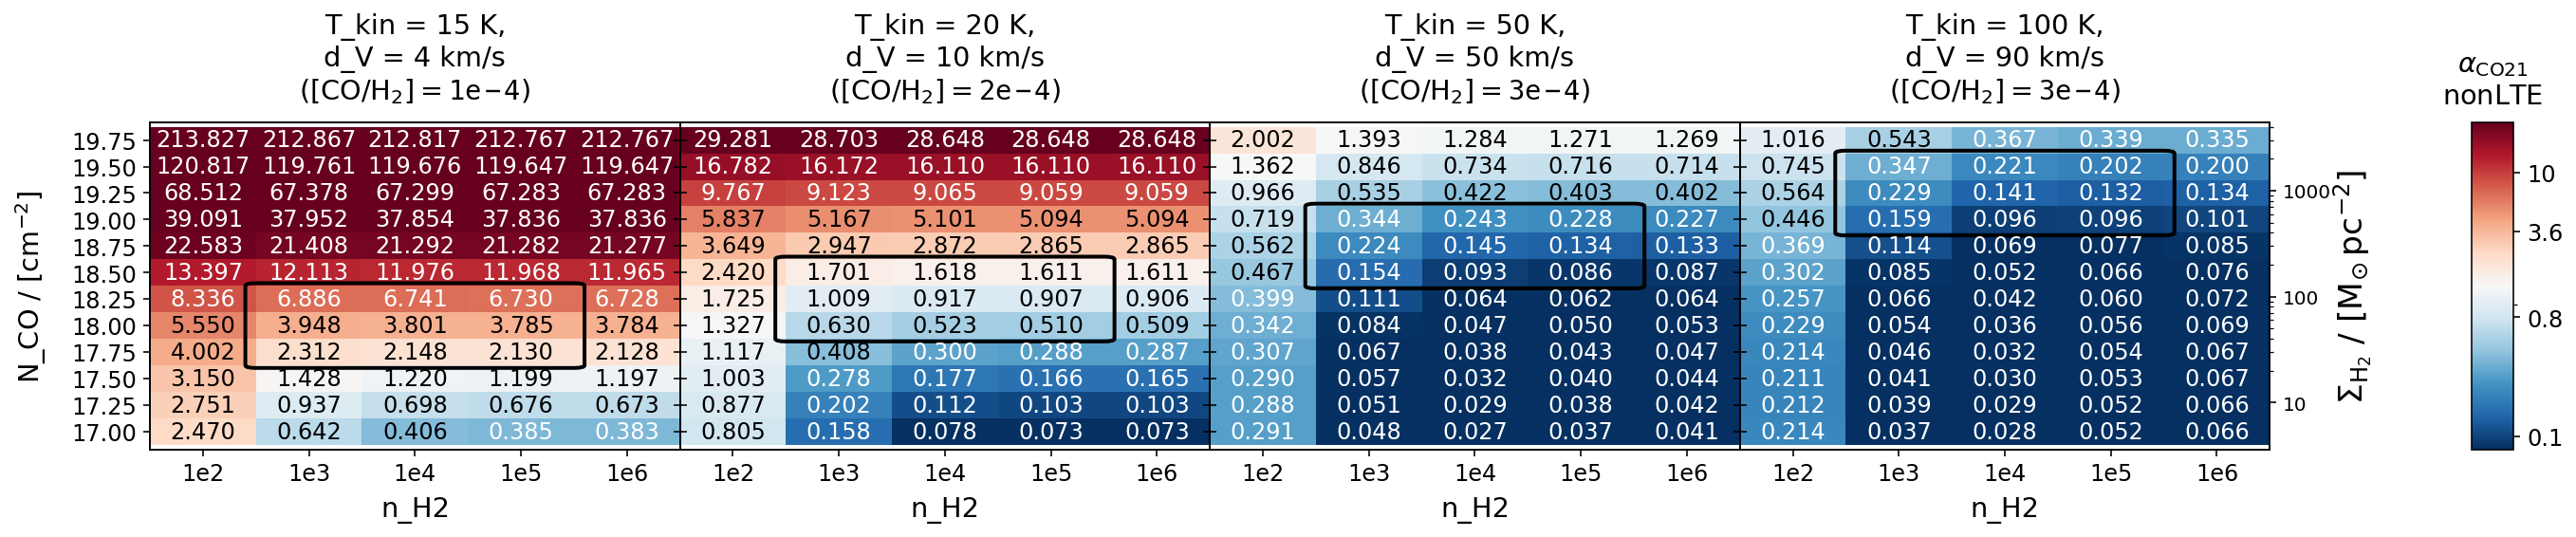

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import ticker

#minima = np.min(data_table['alpha_CO10_NonLTE'])
#maxima = np.max(data_table['alpha_CO10_NonLTE'])
#print('minima', minima, 'maxima', maxima)
minima, maxima = 0.08, 24.0
print('minima', minima, 'maxima', maxima)
# norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
norm = matplotlib.colors.LogNorm(vmin=minima, vmax=maxima, clip=True)
cmap = cm.RdBu_r # cm.jet # cm.viridis # cm.RdYlBu_r
colormapper = cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure(figsize=out_fig_size)
fig.subplots_adjust(**out_fig_margin)
gs = gridspec.GridSpec(ncols=len(list_of_T_kin)+2, nrows=1, figure=fig, 
                       width_ratios=[1]*len(list_of_T_kin)+[0.38,0.08], wspace=0, hspace=0)
axes = []
for i in range(len(list_of_T_kin)):
    ax = fig.add_subplot(gs[0, i])
    axes.append(ax)
right_axes = []
for iax, T_kin in enumerate(list_of_T_kin):
    d_V = list_of_d_V_for_T_kin[iax]
    T_kin_str = '%.0f'%(T_kin)
    d_V_str = '%.0f'%(d_V)
    CO_abundance = list_of_CO_abundance_for_T_kin[iax]
    CO_abundance_str = '{:g}e{:g}'.format(CO_abundance/10**np.floor(np.log10(CO_abundance)), 
                                          np.floor(np.log10(CO_abundance)))
    axes[iax].set_xlabel('n_H2', fontsize='x-large', labelpad=6)
    axes[iax].set_xlim([0, len(list_of_n_H2)])
    axes[iax].set_xticks(np.arange(len(list_of_n_H2))+0.5)
    axes[iax].set_xticklabels([('%.0e'%(t)).replace('e+0','e') for t in list_of_n_H2])
    axes[iax].set_ylim([0, len(list_of_N_CO)])
    axes[iax].set_yticks(np.arange(len(list_of_N_CO))+0.5)
    if iax == 0: 
        axes[iax].set_ylabel(r'N_CO / [cm$^{-2}$]', fontsize='x-large', labelpad=12)
        axes[iax].set_yticklabels(['%.2f'%(np.log10(t)) for t in list_of_N_CO])
    else:
        axes[iax].set_yticklabels([])
    axes[iax].tick_params(labelsize='large')
    axes[iax].set_aspect(0.25)
    #axes[iax].set_title(f'T_kin = {T_kin_str} K,' + '\n' + f'd_V = {d_V_str} km/s', fontsize='x-large', pad=12)
    axes[iax].set_title(f'T_kin = {T_kin_str} K,' + '\n' + \
                        f'd_V = {d_V_str} km/s' + '\n' + \
                        r'($[{\mathrm{CO}}/{\mathrm{H_2}}]={\tt{%s}})$'%(CO_abundance_str), 
                        fontsize='x-large', pad=12) # panel title
    right_axes.append(axes[iax].twinx())
    right_axes[iax].set_aspect(0.25)
    right_axes[iax].set_yticks(np.arange(len(list_of_N_CO))+0.5)
    right_axes[iax].set_yticklabels([])
    right_axes[iax].set_ylim(axes[iax].get_ylim())

ax_colorbar = fig.add_subplot(gs[0, -1])
ax_colorbar.set_title(r'$\alpha_{\mathrm{CO21}}$'+'\n'+r'$\mathrm{nonLTE}$', 
                      fontsize='x-large', pad=10)
ax_colorbar.tick_params(labelsize='large')
cbar = fig.colorbar(mappable=colormapper, cax=ax_colorbar)
cbar.set_ticks([0.1, 0.8, 3.6, 10.0])
cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
cbar.ax.yaxis.set_minor_formatter(ticker.NullFormatter())
cbar.ax.yaxis.set_minor_locator(ticker.LogLocator())

for iy, N_CO in enumerate(list_of_N_CO):
    for ix, n_H2 in enumerate(list_of_n_H2):
        for iax, T_kin in enumerate(list_of_T_kin):
            # 
            d_V = list_of_d_V_for_T_kin[iax]
            d_V_str = '%g'%(d_V)
            data_table = data_table_by_d_V[d_V_str]
            # 
            ax = axes[iax]
            #irow = iy*4*3 + ix*3 + iax #<TODO># n(nH2)=4, n(Tkin)=3
            irow = np.argwhere(np.logical_and.reduce((
                np.isclose(np.log10(data_table['N_CO']), np.log10(N_CO)), 
                np.isclose(np.log10(data_table['n_H2']), np.log10(n_H2)), 
                np.isclose(data_table['T_kin'], T_kin), 
            ))).ravel()
            if len(irow) > 0:
                irow = irow[0]
            else:
                continue
            # 
            R_CI10CO21_NonLTE = data_table['alpha_CO21_NonLTE'][irow]
            #R_CI10CO21_LTE = data_table['alpha_CO10_LTE'][irow]
            x = n_H2
            y = N_CO
            #v = R_CI10CO21_LTE
            v = R_CI10CO21_NonLTE
            ax.fill_between([ix, ix+1], [iy, iy], [iy+1, iy+1], color=colormapper.to_rgba(v), alpha=1.0, lw=0.0)
            if v < 0.4 or v > 6.0:
                text_color = 'w'
            else:
                text_color = 'k'
            ax.text(ix+0.5, iy+0.5, '{:.3f}'.format(v), 
                    ha='center', va='center', color=text_color, fontsize='large')

# show top left text
#ax = axes[0]
#CO_abundance = list_of_CO_abundance_for_T_kin[0]
#CO_abundance_str = '{:g}e{:g}'.format(CO_abundance/10**np.floor(np.log10(CO_abundance)), 
#                                      np.floor(np.log10(CO_abundance)))
#ax.text(-0.30, 1.06, r'($[{\mathrm{CO}}/{\mathrm{H_2}}]={\tt{%s}})$'%(CO_abundance_str), 
#        ha='left', va='bottom', fontsize='x-large', transform=ax.transAxes)

# add a right y axis
ax = axes[-1]
axRight = right_axes[-1]
CO_abundance = list_of_CO_abundance_for_T_kin[-1]
y_tick_lim = np.array([0.5, len(list_of_N_CO)-1+0.5]) # [0.5, N-1+0.5]
y_value_lim = np.array([np.min(np.log10(list_of_N_CO)), np.max(np.log10(list_of_N_CO))])
y_value_lim =  np.array([y_value_lim[0]-(y_value_lim[1]-y_value_lim[0])*0.5/float(y_tick_lim[1]-y_tick_lim[0]),
                         y_value_lim[1]+(y_value_lim[1]-y_value_lim[0])*0.5/float(y_tick_lim[1]-y_tick_lim[0])])
right_y_value_lim = (10**y_value_lim) / CO_abundance * 1.60141791e-20 
                  # (const.m_p+const.m_p-const.m_e) * ((1.*u.pc).to(u.cm).value)**2 / \
                  # const.M_sun = 1.60141791e-20
right_y_value_lim = np.log10(right_y_value_lim)
right_y_value_list = np.array([10., 100., 1000., 10000.])
right_y_tick_list = (np.log10(right_y_value_list) - right_y_value_lim[0]) / \
                    (right_y_value_lim[1] - right_y_value_lim[0]) * (y_tick_lim[1] - y_tick_lim[0] + 1)
axRight.set_yticks(right_y_tick_list)
axRight.set_yticklabels(['%.0f'%(t) for t in right_y_value_list])
axRight.set_ylabel(r'${\Sigma_{\mathrm{H_2}}}$ / [$\mathrm{M_{\odot}\,pc^{-2}}$]', 
                   fontsize='xx-large', labelpad=0) # show right y axis title in the last column panel
right_y_minor_tick_value_list = [] # manually determine minor tick locations
for y_value in right_y_value_list:
    right_y_minor_tick_value_list.extend((y_value * np.arange(2., 9.+1., 1.)).tolist())
right_y_minor_tick_pos_list = (np.log10(right_y_minor_tick_value_list) - right_y_value_lim[0]) / \
                              (right_y_value_lim[1] - right_y_value_lim[0]) * \
                              (y_tick_lim[1] - y_tick_lim[0] + 1)
axRight.set_yticks(right_y_minor_tick_pos_list, minor=True)
axRight.set_ylim(ax.get_ylim())

# add a highlighting box in each panel manually 
# to indicate the physically most plausible n_H2 and N_CO ranges
add_fancy_box(axes, list_of_n_H2, list_of_N_CO)

# save fig
print('Output to {!r}'.format(out_fig_name+'_NonLTE.pdf'))
fig.savefig(out_fig_name+'_NonLTE.pdf', dpi=300)

minima 0.5 maxima 2.0
y_tick_lim [ 0.5 11.5]
delta_y 0.125
y_value_lim [16.875 19.875]
right_y_value_lim [4.00298006e+00 4.00298006e+03]
right_y_tick_list [ 1.59046629  5.59046629  9.59046629 13.59046629]
Output to 'Plot_RADEX_alpha_CO21_varied_CO_abundance_R_NonLTE_LTE.pdf'


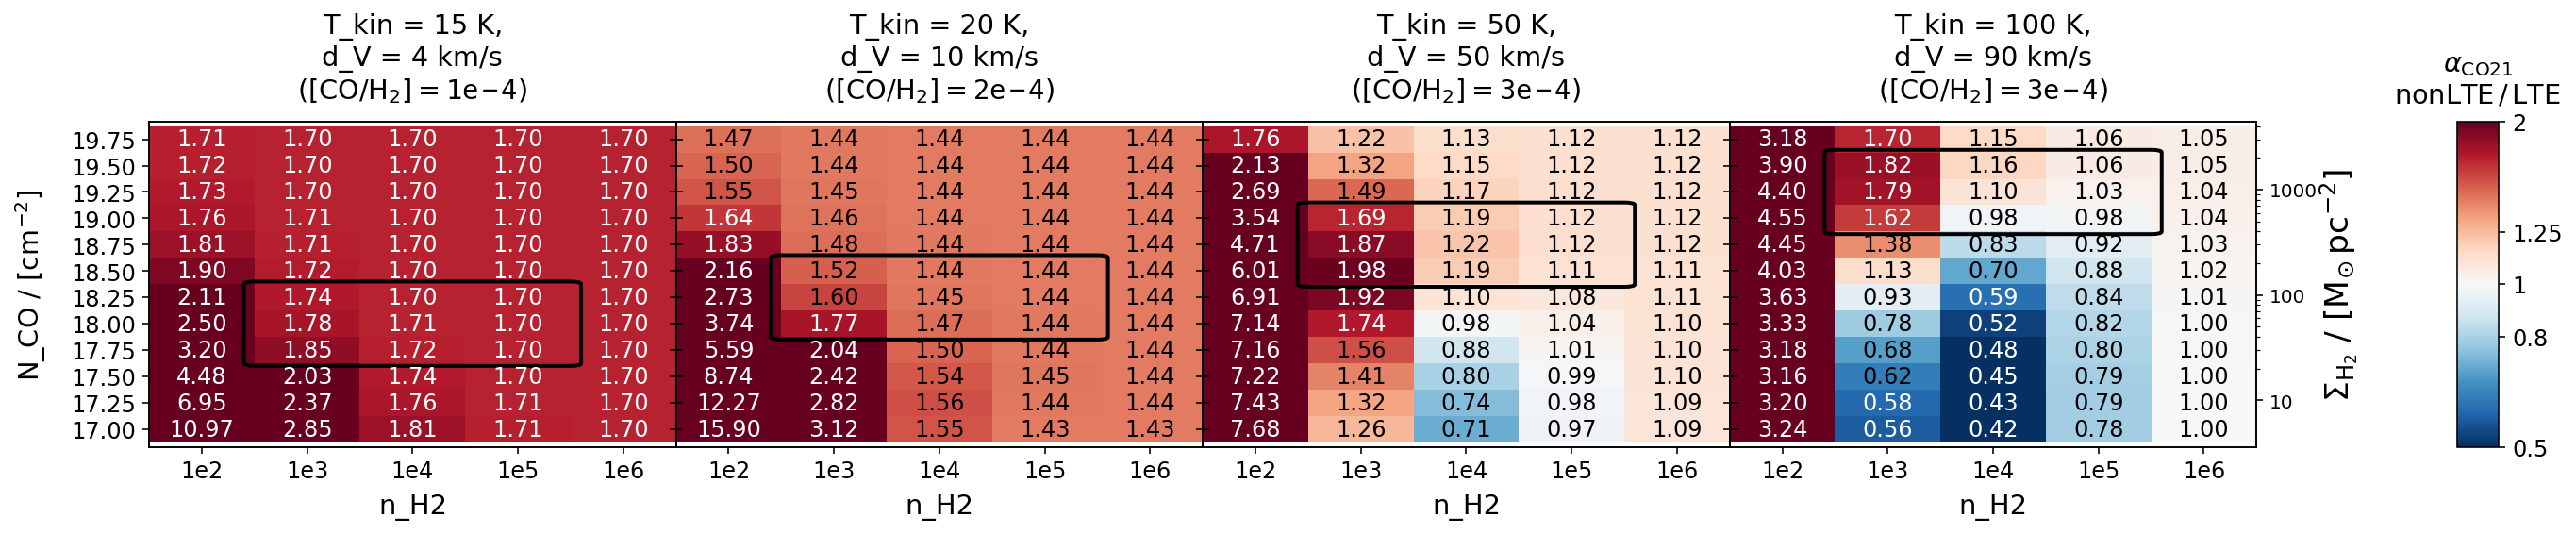

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import ticker

#minima = np.min(data_table['alpha_CO10_NonLTE']/data_table['alpha_CO10_LTE'])
#maxima = np.max(data_table['alpha_CO10_NonLTE']/data_table['alpha_CO10_LTE'])
#print('minima', minima, 'maxima', maxima)
minima = 0.5
maxima = 2.0
print('minima', minima, 'maxima', maxima)
# norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
norm = matplotlib.colors.LogNorm(vmin=minima, vmax=maxima, clip=True)
cmap = cm.RdBu_r # cm.jet # cm.viridis # cm.RdYlBu_r
colormapper = cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure(figsize=out_fig_size)
fig.subplots_adjust(**out_fig_margin)
gs = gridspec.GridSpec(ncols=len(list_of_T_kin)+2, nrows=1, figure=fig, 
                       width_ratios=[1]*len(list_of_T_kin)+[0.38,0.08], wspace=0, hspace=0)
axes = []
for i in range(len(list_of_T_kin)):
    ax = fig.add_subplot(gs[0, i])
    axes.append(ax)
right_axes = []
for iax, T_kin in enumerate(list_of_T_kin):
    d_V = list_of_d_V_for_T_kin[iax]
    T_kin_str = '%.0f'%(T_kin)
    d_V_str = '%.0f'%(d_V)
    CO_abundance = list_of_CO_abundance_for_T_kin[iax]
    CO_abundance_str = '{:g}e{:g}'.format(CO_abundance/10**np.floor(np.log10(CO_abundance)), 
                                          np.floor(np.log10(CO_abundance)))
    axes[iax].set_xlabel('n_H2', fontsize='x-large', labelpad=6)
    if iax == 0: 
        axes[iax].set_ylabel(r'N_CO / [cm$^{-2}$]', fontsize='x-large', labelpad=12)
    axes[iax].set_xlabel('n_H2', fontsize='x-large', labelpad=6)
    axes[iax].set_xlim([0, len(list_of_n_H2)])
    axes[iax].set_xticks(np.arange(len(list_of_n_H2))+0.5)
    axes[iax].set_xticklabels([('%.0e'%(t)).replace('e+0','e') for t in list_of_n_H2])
    axes[iax].set_ylim([0, len(list_of_N_CO)])
    axes[iax].set_yticks(np.arange(len(list_of_N_CO))+0.5)
    if iax == 0: 
        axes[iax].set_ylabel(r'N_CO / [cm$^{-2}$]', fontsize='x-large', labelpad=12)
        axes[iax].set_yticklabels(['%.2f'%(np.log10(t)) for t in list_of_N_CO])
    else:
        axes[iax].set_yticklabels([])
    axes[iax].tick_params(labelsize='large')
    axes[iax].set_aspect(0.25)
    #axes[iax].set_title(f'T_kin = {T_kin_str} K,' + '\n' + f'd_V = {d_V_str} km/s', fontsize='x-large', pad=12)
    axes[iax].set_title(f'T_kin = {T_kin_str} K,' + '\n' + \
                        f'd_V = {d_V_str} km/s' + '\n' + \
                        r'($[{\mathrm{CO}}/{\mathrm{H_2}}]={\tt{%s}})$'%(CO_abundance_str), 
                        fontsize='x-large', pad=12) # panel title
    right_axes.append(axes[iax].twinx())
    right_axes[iax].set_aspect(0.25)
    right_axes[iax].set_yticks(np.arange(len(list_of_N_CO))+0.5)
    right_axes[iax].set_yticklabels([])
    right_axes[iax].set_ylim(axes[iax].get_ylim())

ax_colorbar = fig.add_subplot(gs[0, -1])
ax_colorbar.set_title(r'$\alpha_{\mathrm{CO21}}$'+'\n'+r'$\mathrm{nonLTE} \, / \, \mathrm{LTE}$', 
                      fontsize='x-large', pad=10)
ax_colorbar.tick_params(labelsize='large')
cbar = fig.colorbar(mappable=colormapper, cax=ax_colorbar)
cbar.set_ticks([0.5, 0.80, 1.0, 1.25, 2.0])
cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
cbar.ax.yaxis.set_minor_formatter(ticker.NullFormatter())
cbar.ax.yaxis.set_minor_locator(ticker.LogLocator())

for iy, N_CO in enumerate(list_of_N_CO):
    for ix, n_H2 in enumerate(list_of_n_H2):
        for iax, T_kin in enumerate(list_of_T_kin):
            # 
            d_V = list_of_d_V_for_T_kin[iax]
            d_V_str = '%g'%(d_V)
            data_table = data_table_by_d_V[d_V_str]
            # 
            ax = axes[iax]
            #irow = iy*3*3 + ix*3 + iax
            irow = np.argwhere(np.logical_and.reduce((
                np.isclose(np.log10(data_table['N_CO']), np.log10(N_CO)), 
                np.isclose(np.log10(data_table['n_H2']), np.log10(n_H2)), 
                np.isclose(data_table['T_kin'], T_kin), 
            ))).ravel()
            if len(irow) > 0:
                irow = irow[0]
            else:
                continue
            # 
            R_CI10CO21_NonLTE = data_table['alpha_CO21_NonLTE'][irow]
            R_CI10CO21_LTE = data_table['alpha_CO21_LTE'][irow]
            x = n_H2
            y = N_CO
            v = R_CI10CO21_NonLTE/R_CI10CO21_LTE
            ax.fill_between([ix, ix+1], [iy, iy], [iy+1, iy+1], color=colormapper.to_rgba(v), alpha=1.0, lw=0.0)
            if v < 0.6 or v > 1.6:
                text_color = 'w'
            else:
                text_color = 'k'
            ax.text(ix+0.5, iy+0.5, '{:.2f}'.format(v), 
                    ha='center', va='center', color=text_color, fontsize='large')

# show top left text
#ax = axes[0]
#CO_abundance = list_of_CO_abundance_for_T_kin[0]
#CO_abundance_str = '{:g}e{:g}'.format(CO_abundance/10**np.floor(np.log10(CO_abundance)), 
#                                      np.floor(np.log10(CO_abundance)))
#ax.text(-0.30, 1.06, r'($[{\mathrm{CO}}/{\mathrm{H_2}}]={\tt{%s}})$'%(CO_abundance_str), 
#        ha='left', va='bottom', fontsize='x-large', transform=ax.transAxes)

# add a right y axis
ax = axes[-1]
axRight = right_axes[-1]
CO_abundance = list_of_CO_abundance_for_T_kin[-1]
y_tick_lim = np.array([0.5, len(list_of_N_CO)-1+0.5]) # [0.5, N-1+0.5]
print('y_tick_lim', y_tick_lim)
y_value_lim = np.array([np.min(np.log10(list_of_N_CO)), np.max(np.log10(list_of_N_CO))])
print('delta_y', (y_value_lim[1]-y_value_lim[0])*0.5/float(y_tick_lim[1]-y_tick_lim[0]))
y_value_lim =  np.array([y_value_lim[0]-(y_value_lim[1]-y_value_lim[0])*0.5/float(y_tick_lim[1]-y_tick_lim[0]),
                         y_value_lim[1]+(y_value_lim[1]-y_value_lim[0])*0.5/float(y_tick_lim[1]-y_tick_lim[0])])
print('y_value_lim', y_value_lim)
right_y_value_lim = (10**y_value_lim) / CO_abundance * 1.60141791e-20 
                  # (const.m_p+const.m_p-const.m_e) * ((1.*u.pc).to(u.cm).value)**2 / \
                  # const.M_sun = 1.60141791e-20
print('right_y_value_lim', right_y_value_lim)
right_y_value_lim = np.log10(right_y_value_lim)
right_y_value_list = np.array([10., 100., 1000., 10000.])
right_y_tick_list = (np.log10(right_y_value_list) - right_y_value_lim[0]) / \
                    (right_y_value_lim[1] - right_y_value_lim[0]) * (y_tick_lim[1] - y_tick_lim[0] + 1)
print('right_y_tick_list', right_y_tick_list)
axRight.set_yticks(right_y_tick_list)
axRight.set_yticklabels(['%.0f'%(t) for t in right_y_value_list])
axRight.set_ylabel(r'${\Sigma_{\mathrm{H_2}}}$ / [$\mathrm{M_{\odot}\,pc^{-2}}$]', 
                   fontsize='xx-large', labelpad=0) # show right y axis title in the last column panel
right_y_minor_tick_value_list = [] # manually determine minor tick locations
for y_value in right_y_value_list:
    right_y_minor_tick_value_list.extend((y_value * np.arange(2., 9.+1., 1.)).tolist())
right_y_minor_tick_pos_list = (np.log10(right_y_minor_tick_value_list) - right_y_value_lim[0]) / \
                              (right_y_value_lim[1] - right_y_value_lim[0]) * \
                              (y_tick_lim[1] - y_tick_lim[0] + 1)
axRight.set_yticks(right_y_minor_tick_pos_list, minor=True)
axRight.set_ylim(ax.get_ylim())

# add a highlighting box in each panel manually 
# to indicate the physically most plausible n_H2 and N_CO ranges
add_fancy_box(axes, list_of_n_H2, list_of_N_CO)

# save fig
print('Output to {!r}'.format(out_fig_name+'_R_NonLTE_LTE.pdf'))
fig.savefig(out_fig_name+'_R_NonLTE_LTE.pdf', dpi=300)